# Visualize Results: Downstream Performance - "Fully Observed" Experiment

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT = "fully_observed_fix"

EXPERIMENT_PATH = Path(f"../data/experiments/{EXPERIMENT}/")

CLF_METRIC = "Classification Tasks"
REG_METRIC = "Regression Tasks"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"
IMPUTE_RESULT_TYPE = "impute_performance_mean"

FIGURES_PATH = Path(f"../paper/figures/")

## Import the data

In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 26s, sys: 4.33 s, total: 1min 30s
Wall time: 1min 40s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed_fix,AutoKerasImputer,40922,MAR,0.01,single_single,gyro_y,impute_performance_std,MAE,0.106241,1.587225,NaN,NaN,NaN
1,fully_observed_fix,AutoKerasImputer,40922,MAR,0.01,single_single,gyro_y,impute_performance_std,MSE,7.241522,33.737118,NaN,NaN,NaN
2,fully_observed_fix,AutoKerasImputer,40922,MAR,0.01,single_single,gyro_y,impute_performance_std,RMSE,0.437626,1.964970,NaN,NaN,NaN
3,fully_observed_fix,AutoKerasImputer,40922,MAR,0.30,single_single,gyro_y,impute_performance_std,MAE,0.313879,0.533029,NaN,NaN,NaN
4,fully_observed_fix,AutoKerasImputer,40922,MAR,0.30,single_single,gyro_y,impute_performance_std,MSE,5.302641,9.211569,NaN,NaN,NaN


In [5]:
na_impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "RMSE"]))
]
na_impute_results.drop(["baseline", "corrupted", "imputed"], axis=1, inplace=True)
na_impute_results = na_impute_results[na_impute_results.isna().any(axis=1)]
na_impute_results.shape

(276, 11)

In [6]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "RMSE"]))
]

# remove experiments where imputation failed
downstream_results = downstream_results.merge(
    na_impute_results,
    how = "left",
    validate = "one_to_one",
    indicator = True,
    suffixes=("", "_imp"),
    on = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "column"]
)
downstream_results = downstream_results[downstream_results["_merge"]=="left_only"]

assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "result_type_imp", "metric_imp", "train", "test", "train_imp", "test_imp", "_merge"], axis=1, inplace=True)

downstream_results = downstream_results.rename(
    {
        "imputer": "Imputation Method",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "baseline": "Baseline",
        "imputed": "Imputed",
        "corrupted": "Corrupted"
    },
    axis = 1
)

In [7]:
rename_imputer_dict = {
    "ModeImputer": "Mean/Mode",
    "KNNImputer": "$k$-NN",
    "ForestImputer": "Random Forest",
    "AutoKerasImputer": "Discriminative DL",
    "VAEImputer": "VAE",
    "GAINImputer": "GAIN"    
}

rename_metric_dict = {
    "F1_macro": CLF_METRIC,
    "RMSE": REG_METRIC
}

downstream_results = downstream_results.replace(rename_imputer_dict)
downstream_results = downstream_results.replace(rename_metric_dict)

downstream_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed
0,Discriminative DL,40922,MAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735582,0.735822
1,Discriminative DL,40922,MAR,0.30,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.725199,0.731309
2,Discriminative DL,40922,MAR,0.50,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.720784,0.732196
3,Discriminative DL,40922,MAR,0.10,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735289,0.735309
4,Discriminative DL,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735530,0.735632
...,...,...,...,...,...,...,...,...,...,...
4951,GAIN,1471,MCAR,0.10,V9,downstream_performance_mean,Classification Tasks,0.508405,0.497643,0.515090
4952,GAIN,1471,MNAR,0.01,V9,downstream_performance_mean,Classification Tasks,0.508405,0.506586,0.508398
4953,GAIN,1471,MNAR,0.30,V9,downstream_performance_mean,Classification Tasks,0.508405,0.480143,0.530432
4954,GAIN,1471,MNAR,0.50,V9,downstream_performance_mean,Classification Tasks,0.508405,0.451953,0.498481


### Check if results are complete

In [8]:
# should have equal length
downstream_results["Imputation Method"].value_counts(dropna=False)

Mean/Mode            828
Random Forest        828
$k$-NN               828
VAE                  828
Discriminative DL    827
GAIN                 553
Name: Imputation Method, dtype: int64

### Robustness: check which imputers yielded `NaN`values

In [9]:
for col in downstream_results.columns:
    na_sum = downstream_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = downstream_results[col].isna()
        print(downstream_results.loc[na_idx, "Imputation Method"].value_counts(dropna=False))
        print("\n")

## Compute Downstream Performance relative to Baseline

In [10]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [11]:
downstream_results["Improvement"]   = (downstream_results["Imputed"] - downstream_results["Corrupted"]  ) / downstream_results["Baseline"]
downstream_results.loc[reg_row_idx, "Improvement"]   = downstream_results.loc[reg_row_idx, "Improvement"]   * -1

downstream_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Improvement
0,Discriminative DL,40922,MAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735582,0.735822,0.000326
1,Discriminative DL,40922,MAR,0.30,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.725199,0.731309,0.008306
2,Discriminative DL,40922,MAR,0.50,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.720784,0.732196,0.015513
3,Discriminative DL,40922,MAR,0.10,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735289,0.735309,0.000028
4,Discriminative DL,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.735632,0.735530,0.735632,0.000138
...,...,...,...,...,...,...,...,...,...,...,...
4951,GAIN,1471,MCAR,0.10,V9,downstream_performance_mean,Classification Tasks,0.508405,0.497643,0.515090,0.034317
4952,GAIN,1471,MNAR,0.01,V9,downstream_performance_mean,Classification Tasks,0.508405,0.506586,0.508398,0.003565
4953,GAIN,1471,MNAR,0.30,V9,downstream_performance_mean,Classification Tasks,0.508405,0.480143,0.530432,0.098914
4954,GAIN,1471,MNAR,0.50,V9,downstream_performance_mean,Classification Tasks,0.508405,0.451953,0.498481,0.091519


## Application Scenario 2 - Downstream Performance

### Categorical  Columns (Classification)

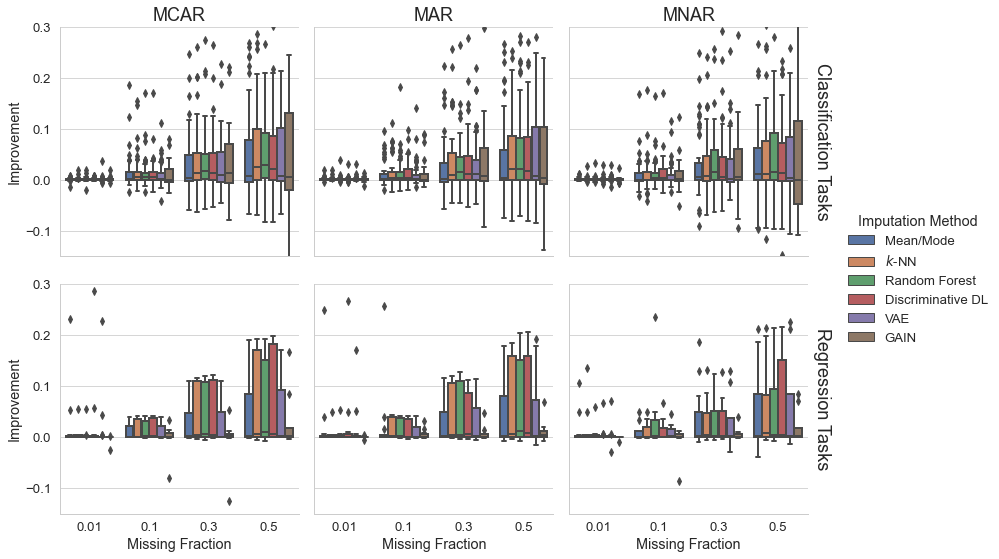

In [13]:
draw_cat_box_plot(
    downstream_results,
    "Improvement",
    (-0.15, 0.3),
    FIGURES_PATH,
    "fully_observed_downstream_boxplot.eps",
    hue_order=list(rename_imputer_dict.values()),
    row_order=list(rename_metric_dict.values())
)